In [1]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='OR7Qs2eAtUhM2FypNwTUd7YZAVKqZKaa6OUqbYC76WVm',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.au-syd.cloud-object-storage.appdomain.cloud')

bucket = 'armsdetection-donotdelete-pr-lpqgsv8m7rxept'
object_key = 'archive (3).zip'

# load data of type "application/zip" into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/

streaming_body_1 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']



In [2]:
import zipfile
from io import BytesIO

# Read the content of the StreamingBody into memory
zip_content = streaming_body_1.read()

# Use BytesIO to convert the byte content into a file-like object
zip_file = BytesIO(zip_content)

# Now you can extract the files using zipfile
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # Extract the contents into a local directory (change the path as needed)
    zip_ref.extractall('./extracted_files')  # This will extract to a folder named 'extracted_files'

print("Files extracted successfully!")


Files extracted successfully!


In [3]:
import os

# Path to the folder where files were extracted
extracted_dir = './extracted_files'

# List the extracted files
if os.path.exists(extracted_dir):
    for root, dirs, files in os.walk(extracted_dir):
        for file in files:
            print(f"Extracted file: {os.path.join(root, file)}")
else:
    print("No files were extracted or directory doesn't exist.")


Extracted file: ./extracted_files/metadata.csv
Extracted file: ./extracted_files/weapon_detection/train/images/Knife_95.jpeg
Extracted file: ./extracted_files/weapon_detection/train/images/Sword_35.png
Extracted file: ./extracted_files/weapon_detection/train/images/Sword_90.jpeg
Extracted file: ./extracted_files/weapon_detection/train/images/Sniper_79.jpeg
Extracted file: ./extracted_files/weapon_detection/train/images/Shotgun_41.jpeg
Extracted file: ./extracted_files/weapon_detection/train/images/Bazooka_20.jpeg
Extracted file: ./extracted_files/weapon_detection/train/images/Bazooka_42.jpeg
Extracted file: ./extracted_files/weapon_detection/train/images/Automatic Rifle_49.jpeg
Extracted file: ./extracted_files/weapon_detection/train/images/Bazooka_81.jpeg
Extracted file: ./extracted_files/weapon_detection/train/images/SMG_43.jpeg
Extracted file: ./extracted_files/weapon_detection/train/images/Bazooka_30.jpeg
Extracted file: ./extracted_files/weapon_detection/train/images/Knife_49.jpeg

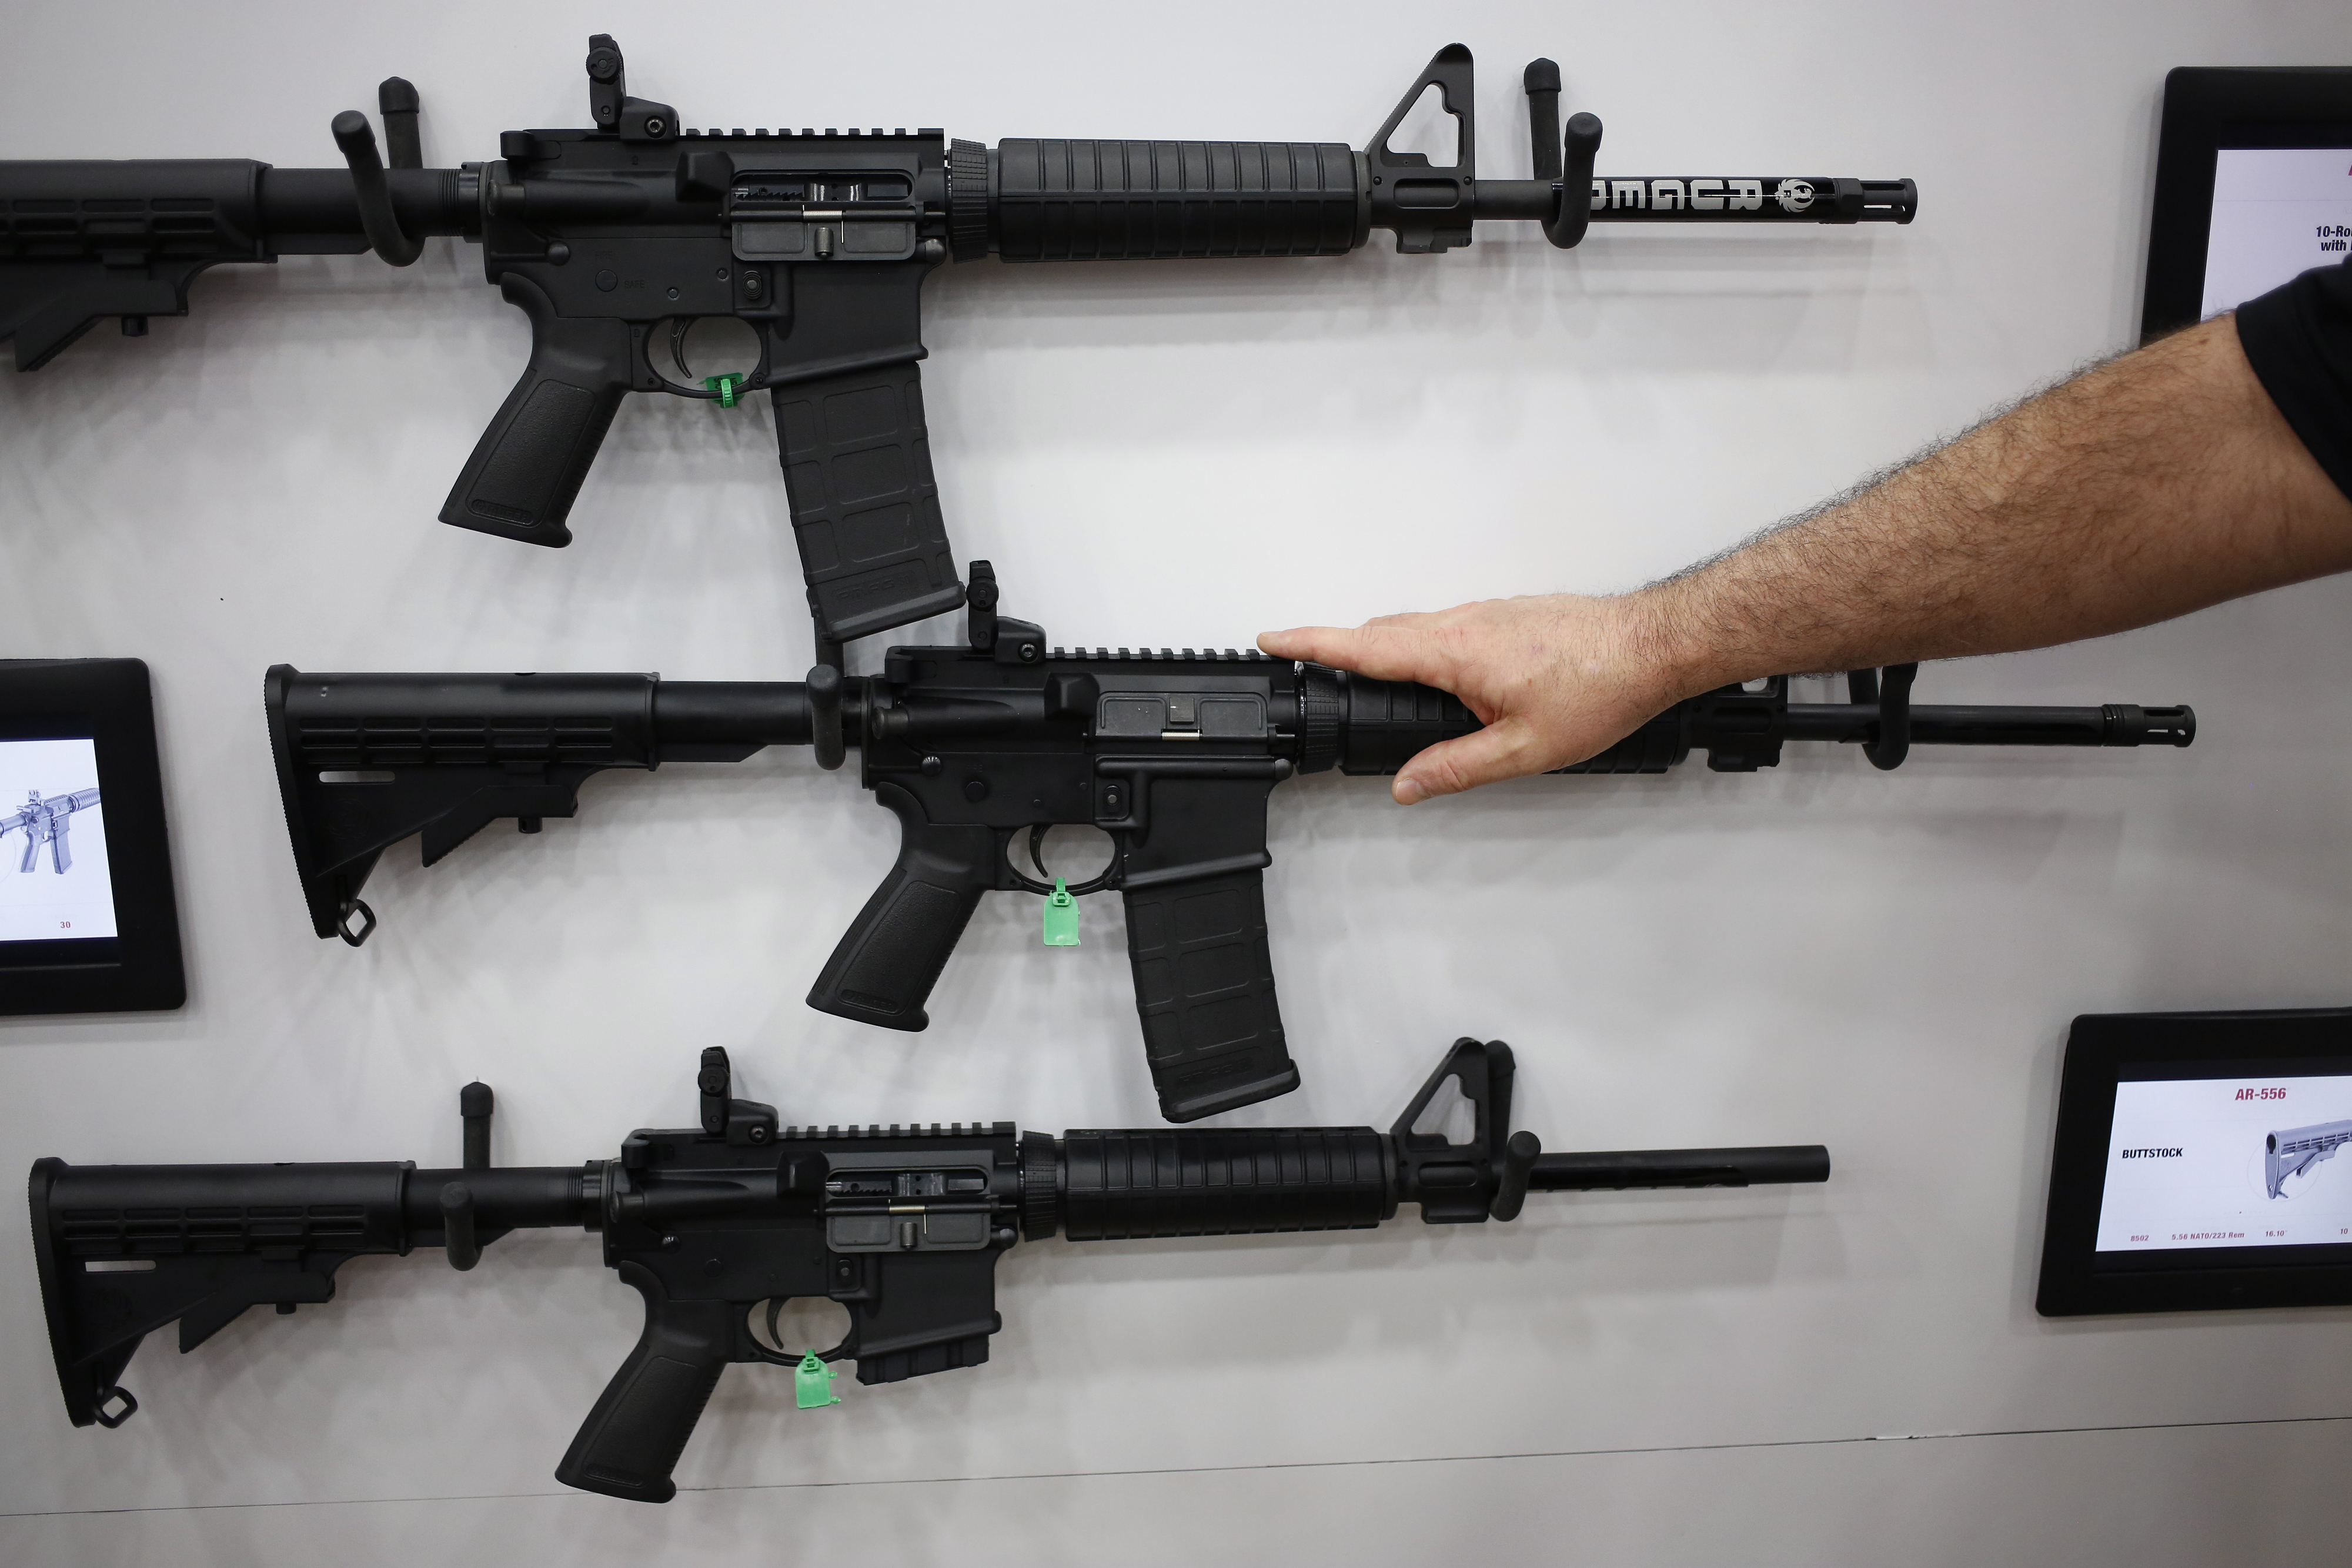

In [6]:
from IPython.display import Image, display

# Path to the specific image
image_path = './extracted_files/weapon_detection/train/images/Automatic Rifle_49.jpeg'

# Display the image
display(Image(filename=image_path))



In [7]:
metadata_path = "./extracted_files/metadata.csv"
metadata = pd.read_csv(metadata_path)

In [8]:
print(metadata)

                    imagefile                labelfile  target  train_id
0     Automatic Rifle_10.jpeg   Automatic Rifle_10.txt       0         1
1    Automatic Rifle_100.jpeg  Automatic Rifle_100.txt       0         1
2     Automatic Rifle_11.jpeg   Automatic Rifle_11.txt       0         1
3     Automatic Rifle_12.jpeg   Automatic Rifle_12.txt       0         1
4     Automatic Rifle_13.jpeg   Automatic Rifle_13.txt       0         0
..                        ...                      ...     ...       ...
709             Sword_95.jpeg             Sword_95.txt       8         1
710             Sword_96.jpeg             Sword_96.txt       8         0
711             Sword_97.jpeg             Sword_97.txt       8         1
712             Sword_98.jpeg             Sword_98.txt       8         1
713             Sword_99.jpeg             Sword_99.txt       8         0

[714 rows x 4 columns]


In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define paths
metadata_path = "./extracted_files/metadata.csv"
base_dir = "./extracted_files"
train_dir = os.path.join(base_dir, "weapon_detection/train/images")
val_dir = os.path.join(base_dir, "weapon_detection/val/images")

# Parameters
img_size = (128, 128)  # Resize images to 128x128
batch_size = 32
epochs = 10

# Load metadata
metadata = pd.read_csv(metadata_path)

# Filter train and validation data (train_id == 1 for train and train_id == 0 for val)
train_metadata = metadata[metadata['train_id'] == 1]
val_metadata = metadata[metadata['train_id'] == 0]

# Load and preprocess images and labels for training data
def load_data(metadata, base_dir, img_size, folder="train"):
    images = []
    labels = []
    for _, row in metadata.iterrows():
        # Construct the path to the image
        image_path = os.path.join(base_dir, f"weapon_detection/{folder}/images", row['imagefile'])
        
        # Load and preprocess image
        img = load_img(image_path, target_size=img_size)
        img = img_to_array(img) / 255.0  # Normalize image
        images.append(img)
        
        # Use target as the label
        labels.append(row['target'])
    return np.array(images), np.array(labels)

# Load training data (train folder)
X_train, y_train = load_data(train_metadata, base_dir, img_size, folder="train")

# Load validation data (val folder)
X_val, y_val = load_data(val_metadata, base_dir, img_size, folder="val")

# Convert labels to one-hot encoding
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of tensor image data
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

# Define the CNN model with increased complexity and dropout
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(*img_size, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Learning rate scheduler function
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.1

# Set up callbacks
lr_callback = LearningRateScheduler(lr_scheduler)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# Train the model using both training and validation data
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=epochs,
                    callbacks=[lr_callback, early_stop, checkpoint])

# Save the final model
model.save("weapon_detection_model_with_val_improved.h5")

# Plot training history (including validation accuracy)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10
18/18 [==============================] - 14s 730ms/step - loss: 2.2000 - accuracy: 0.1261 - val_loss: 2.1963 - val_accuracy: 0.1259 - lr: 0.0010
Epoch 2/10


/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 4/18 [=====>........................] - ETA: 9s - loss: 2.1964 - accuracy: 0.1875

In [19]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd

# Load metadata (if needed, just for reference)
metadata_path = "./extracted_files/metadata.csv"
metadata = pd.read_csv(metadata_path)

# Parameters
img_size = (128, 128)  # Resize images to 128x128

# Define the path to test images
test_dir = os.path.join(base_dir, "test/test")

# Function to load and preprocess images from the test folder
def load_test_images(test_dir, img_size):
    test_images = []
    test_filenames = os.listdir(test_dir)  # Get all filenames in the test directory
    for filename in test_filenames:
        # Construct the full path to each image
        image_path = os.path.join(test_dir, filename)
        
        # Load and preprocess the image
        img = load_img(image_path, target_size=img_size)
        img = img_to_array(img) / 255.0  # Normalize image
        test_images.append(img)
    
    return np.array(test_images), test_filenames

# Load test images
X_test, test_filenames = load_test_images(test_dir, img_size)

# Make predictions on the test images
predictions = model.predict(X_test)

# Get the predicted class labels (since it's a classification problem)
predicted_classes = np.argmax(predictions, axis=1)

# Define the class names (replace these with your actual class names)
class_names = ["Automatic Rifle", "Bazooka", "Grenade Launcher", "Handgun", "Knife", "Shotgun", "SMG", "Sniper", "Sword"]

# Convert predictions to readable class names
predicted_class_names = [class_names[i] for i in predicted_classes]

# For each test image, check for multiple classes (using threshold)
threshold = 0.2  # You can adjust this threshold
for filename, prediction in zip(test_filenames, predictions):
    predicted_class_indices = np.where(prediction > threshold)[0]  # Get classes with confidence > threshold
    predicted_class_names_multiple = [class_names[i] for i in predicted_class_indices]  # Class names
    
    print(f"Image: {filename} -> Predicted Classes: {', '.join(predicted_class_names_multiple)}")

# Optionally: Save results to a CSV file
results_df = pd.DataFrame({
    "Filename": test_filenames,
    "Predicted Classes": [', '.join([class_names[i] for i in np.where(prediction > threshold)[0]]) for prediction in predictions]
})
results_df.to_csv("test_predictions.csv", index=False)



1/1 [==============================] - 0s 31ms/step
Image: giphy.gif -> Predicted Classes: Sword
Image: weaponsgta5.gif -> Predicted Classes: Shotgun, SMG
Image: weapons2.jpg -> Predicted Classes: Shotgun, Sniper
Image: mafia-mafia-game.gif -> Predicted Classes: Knife, Sword
Image: army.jpg -> Predicted Classes: Automatic Rifle, Grenade Launcher
Image: weapons.jpg -> Predicted Classes: Automatic Rifle, Bazooka
Image: terrorists.jpg -> Predicted Classes: Shotgun, Sniper
Image: terrorists2.jpg -> Predicted Classes: SMG


In [16]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd

# Load metadata (if needed, just for reference)
metadata_path = "./extracted_files/metadata.csv"
metadata = pd.read_csv(metadata_path)

# Parameters
img_size = (128, 128)  # Resize images to 128x128

# Define the path to test images
test_dir = os.path.join(base_dir, "test/test")

# Function to load and preprocess images from the test folder
def load_test_images(test_dir, img_size):
    test_images = []
    test_filenames = os.listdir(test_dir)  # Get all filenames in the test directory
    for filename in test_filenames:
        # Construct the full path to each image
        image_path = os.path.join(test_dir, filename)
        
        # Load and preprocess the image
        img = load_img(image_path, target_size=img_size)
        img = img_to_array(img) / 255.0  # Normalize image
        test_images.append(img)
    
    return np.array(test_images), test_filenames

# Load test images
X_test, test_filenames = load_test_images(test_dir, img_size)

# Make predictions on the test images
predictions = model.predict(X_test)

# Get the predicted class labels (since it's a classification problem)
predicted_classes = np.argmax(predictions, axis=1)

# Define the class names (replace these with your actual class names)
class_names = ["Automatic Rifle", "Bazooka", "Grenade Launcher", "Handgun", "Knife", "Shotgun", "SMG", "Sniper", "Sword"]

# Convert predictions to readable class names
predicted_class_names = [class_names[i] for i in predicted_classes]

# Display the predictions along with filenames
for filename, pred_class in zip(test_filenames, predicted_class_names):
    print(f"Image: {filename} -> Predicted Class: {pred_class}")

# Optionally: Save results to a CSV file
results_df = pd.DataFrame({
    "Filename": test_filenames,
    "Predicted Class": predicted_class_names
})
results_df.to_csv("test_predictions.csv", index=False)


1/1 [==============================] - 0s 82ms/step
Image: giphy.gif -> Predicted Class: Sword
Image: weaponsgta5.gif -> Predicted Class: Shotgun
Image: weapons2.jpg -> Predicted Class: Sniper
Image: mafia-mafia-game.gif -> Predicted Class: Knife
Image: army.jpg -> Predicted Class: Automatic Rifle
Image: weapons.jpg -> Predicted Class: Automatic Rifle
Image: terrorists.jpg -> Predicted Class: Shotgun
Image: terrorists2.jpg -> Predicted Class: SMG
